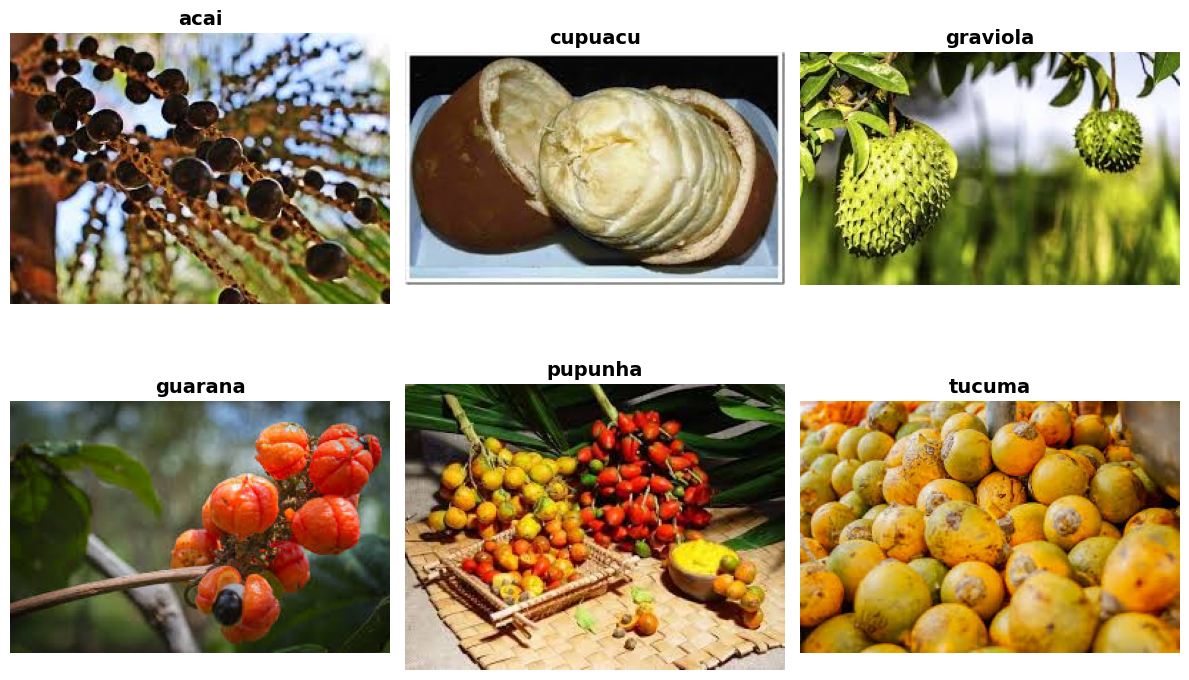

In [55]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

train_dir = '/content/drive/MyDrive/FruitinAmazon/train'

class_dirs = sorted([f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))])[:6]
if len(class_dirs) < 6:
    raise ValueError("Not enough classes in dataset. Ensure there are at least 6 class directories.")

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    if not image_files:
        axes[i].axis('off')
        axes[i].set_title(f"{class_dir} (No Image)", fontsize=12, color='red')
        continue

    image_path = os.path.join(class_path, random.choice(image_files))
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_dir, fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [56]:
def check_corrupted_images(train_dir, remove=False):
    corrupted = []
    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        if not os.path.isdir(class_path): continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')): continue
            try:
                Image.open(img_path).verify()
            except:
                corrupted.append(img_path)
                if remove: os.remove(img_path)
    return corrupted

corrupt_files = check_corrupted_images(train_dir, remove=False)
print(f"Corrupted images: {len(corrupt_files)}")
if corrupt_files: print("\n".join(corrupt_files))

Corrupted images: 0


In [57]:
import tensorflow as tf

img_height, img_width, batch_size, validation_split = 128, 128, 32, 0.2
rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
).map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
).map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [59]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Use Input layer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_dirs), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.1453 - loss: 2.1005
Epoch 1: val_loss improved from inf to 1.23753, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 651ms/step - accuracy: 0.1437 - loss: 2.1365 - val_accuracy: 0.8333 - val_loss: 1.2375
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.1377 - loss: 1.9330
Epoch 2: val_loss did not improve from 1.23753
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - accuracy: 0.1519 - loss: 1.9145 - val_accuracy: 0.1111 - val_loss: 1.7037
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.2546 - loss: 1.7253
Epoch 3: val_loss did not improve from 1.23753
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.2569 - loss: 1.7213 - val_accuracy: 0.0556 - val_loss: 1.8009
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.3050 - loss: 1.6575
Epoch 4: val_loss did not improve from 1.23753
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.3051 - loss: 1.6531 - val_accuracy: 0.50

In [61]:
# Evaluating the model
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8889 - loss: 0.2506
Test Loss: 0.250618577003479
Test Accuracy: 0.8888888955116272


In [62]:
model.save('fruit_classifier_model.h5')
loaded_model = models.load_model('fruit_classifier_model.h5')
test_loss, test_acc = loaded_model.evaluate(val_ds)
print(f"Test Loss (after loading): {test_loss}")
print(f"Test Accuracy (after loading): {test_acc}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8889 - loss: 0.2506
Test Loss (after loading): 0.250618577003479
Test Accuracy (after loading): 0.8888888955116272


In [64]:
import numpy as np
from sklearn.metrics import classification_report
import os

train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
class_dirs = sorted([class_name for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))])
num_classes = len(class_dirs)

y_pred = []
y_true = []

for images, labels in val_ds:
    pred = loaded_model.predict(images)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(labels.numpy())
all_labels = list(range(num_classes))
print(classification_report(y_true, y_pred, labels=all_labels, target_names=class_dirs))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         0
     cupuacu       0.00      0.00      0.00         0
    graviola       0.00      0.00      0.00         0
     guarana       0.00      0.00      0.00         0
     pupunha       1.00      0.67      0.80         3
      tucuma       0.93      0.93      0.93        15

    accuracy                           0.89        18
   macro avg       0.32      0.27      0.29        18
weighted avg       0.94      0.89      0.91        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me